In [2]:
# Import necessary packages
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from nn.nn import NeuralNetwork

# Load the digits dataset
digits = load_digits()

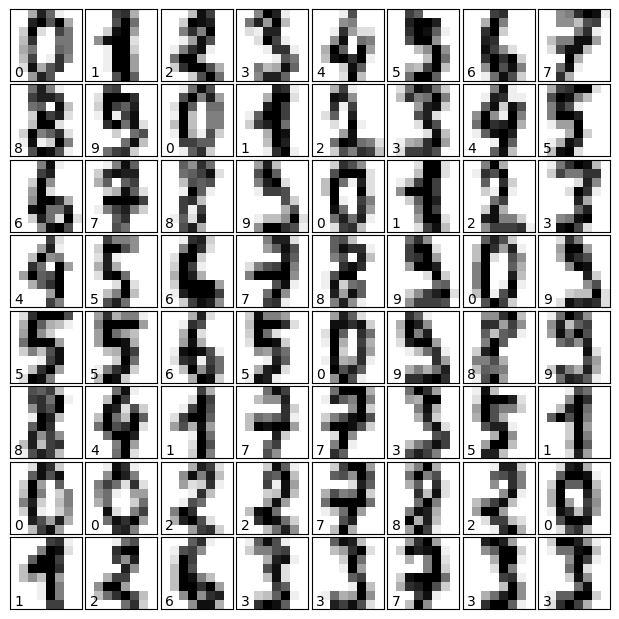

In [3]:
#Visualize the first 64 digits in the digits dataset
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [4]:
X = digits.data  # shape (n_samples, 64)
# Scale the data between 0 and 1 (digits data ranges from 0 to 16)
X = X / 16.0
X

array([[0.    , 0.    , 0.3125, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.625 , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 1.    , 0.5625, 0.    ],
       ...,
       [0.    , 0.    , 0.0625, ..., 0.375 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.75  , 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.75  , 0.0625, 0.    ]],
      shape=(1797, 64))

In [7]:
# Split the data into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

In [9]:
# For an autoencoder, the target output is the same as the input.
y_train = X_train.copy()
y_val = X_val.copy()

In [10]:
# Define the autoencoder architecture: 64 -> 16 -> 64.
# The first layer encodes the input into a 16-dimensional latent space using ReLU,
# and the second layer decodes it back to 64 dimensions using a Sigmoid activation.
nn_arch = [
    {'input_dim': 64, 'output_dim': 16, 'activation': 'relu'},
    {'input_dim': 16, 'output_dim': 64, 'activation': 'sigmoid'}
]

# Define hyperparameters
lr = 0.01          # Learning rate chosen for stable convergence on this small dataset.
seed = 42          # Fixed seed for reproducibility.
batch_size = 10    # A common batch size balancing gradient noise and memory efficiency.
epochs = 100       # Number of epochs chosen to allow sufficient training iterations.
loss_function = "mse"  # Mean Squared Error is standard for reconstruction tasks.

# Create an instance of your NeuralNetwork autoencoder
autoencoder = NeuralNetwork(nn_arch, lr, seed, batch_size, epochs, loss_function)

# Train the autoencoder on the training data.
# Since it's an autoencoder, both the input and the target output are X_train.
train_losses, val_losses = autoencoder.fit(X_train, y_train, X_val, y_val)

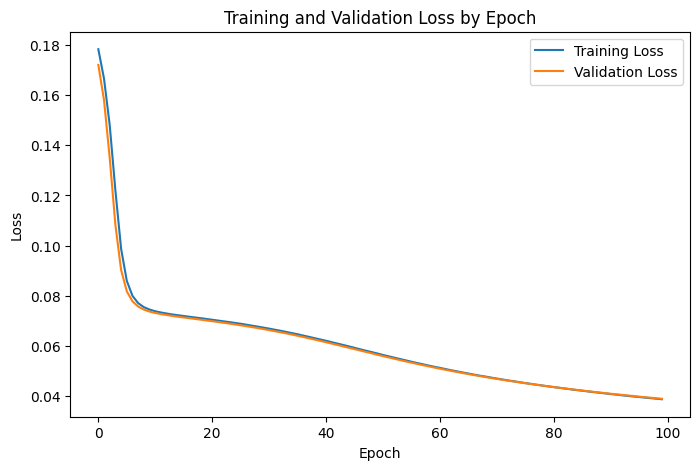

In [11]:
# Plot training and validation loss by epoch
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss by Epoch")
plt.legend()
plt.show()

In [12]:
# Quantify the average reconstruction error over the validation set.
# Here we compute the mean squared error between the input and its reconstruction.
y_pred_val = autoencoder.predict(X_val)
reconstruction_error = np.mean((y_val.T - y_pred_val) ** 2)
print("Average Reconstruction Error on Validation Set:", reconstruction_error)

Average Reconstruction Error on Validation Set: 0.03893721775397236


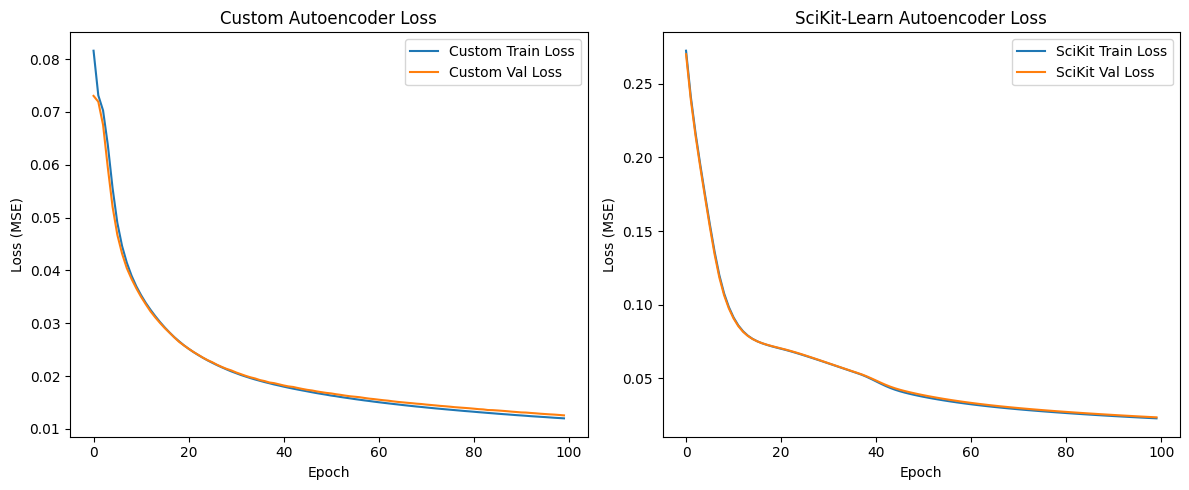

Custom Autoencoder Average Reconstruction Error on Validation Set: 0.012576921906884768
SciKit-Learn Autoencoder Average Reconstruction Error on Validation Set: 0.023590517192801634


In [15]:
# comparing our auto encoder implementation with sci-kit learn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from nn.nn import NeuralNetwork

# Load and normalize the digits dataset.
digits = load_digits()
X = digits.data  # Shape: (n_samples, 64)
X = X / 16.0     # Scale pixel values to [0, 1]

# Split the data into training and validation sets.
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

X_train, X_val1 = train_test_split(X_train, test_size=0.2, random_state=42) #split again to get a completely unbiased set (X_val1, which wasn't used in training or validation

# For an autoencoder, the target output is the same as the input.
y_train = X_train.copy()
y_val = X_val.copy()

# ------------------------------------------------------------
# Setup parameters for both models.
# Architecture: 64 -> 16 -> 64
nn_arch = [
    {'input_dim': 64, 'output_dim': 16, 'activation': 'sigmoid'},
    {'input_dim': 16, 'output_dim': 64, 'activation': 'sigmoid'}
]
lr = 1             # Learning rate
seed = 42          # Random seed for reproducibility
batch_size = 10    # Batch size
epochs = 100       # Number of epochs
loss_function = "mse"  # Loss function

# ------------------------------------------------------------
# 1. Custom Autoencoder using our NeuralNetwork class
custom_autoencoder = NeuralNetwork(nn_arch, lr, seed, batch_size, epochs, loss_function)

# For the custom implementation, both inputs and targets are the same.
# Note: Your fit method expects y to be transposed internally.
train_losses_custom, val_losses_custom = custom_autoencoder.fit(X_train, y_train, X_val, y_val)

# ------------------------------------------------------------
# 2. SciKit-Learn Autoencoder using MLPRegressor
# We mimic the 64x16x64 architecture by using one hidden layer of size 16.
autoencoder_sk = MLPRegressor(hidden_layer_sizes=(16,),
                              activation='relu',      # hidden layer activation
                              solver='adam',
                              warm_start=True,        # enables iterative training
                              max_iter=1,             # we'll iterate manually for each epoch
                              random_state=42)

train_losses_sk = []
val_losses_sk = []
for epoch in range(epochs):
    autoencoder_sk.partial_fit(X_train, y_train)
    train_pred_sk = autoencoder_sk.predict(X_train)
    train_loss_sk = mean_squared_error(X_train, train_pred_sk)
    val_pred_sk = autoencoder_sk.predict(X_val)
    val_loss_sk = mean_squared_error(X_val, val_pred_sk)
    train_losses_sk.append(train_loss_sk)
    val_losses_sk.append(val_loss_sk)
    # Optionally print progress:
    # print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss_sk:.6f}, Val Loss: {val_loss_sk:.6f}")

# ------------------------------------------------------------
# Plot training and validation loss curves for both models.
plt.figure(figsize=(12, 5))

# Custom autoencoder loss plot.
plt.subplot(1, 2, 1)
plt.plot(train_losses_custom, label="Custom Train Loss")
plt.plot(val_losses_custom, label="Custom Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Custom Autoencoder Loss")
plt.legend()

# SciKit-Learn autoencoder loss plot.
plt.subplot(1, 2, 2)
plt.plot(train_losses_sk, label="SciKit Train Loss")
plt.plot(val_losses_sk, label="SciKit Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("SciKit-Learn Autoencoder Loss")
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Compute and print the average reconstruction error on the validation set.
# For the custom autoencoder, note that its output is transposed relative to X_val.
custom_val_pred = custom_autoencoder.predict(X_val)
# Transpose X_val to match the shape of custom_val_pred (features x n_samples).
custom_reconstruction_error = np.mean((X_val.T - custom_val_pred) ** 2)
print("Custom Autoencoder Average Reconstruction Error on Validation Set:", custom_reconstruction_error)

sk_reconstruction_error = mean_squared_error(X_val, autoencoder_sk.predict(X_val))
print("SciKit-Learn Autoencoder Average Reconstruction Error on Validation Set:", sk_reconstruction_error)

Raw prediction shape: (64, 288)
Transposed predictions shape: (288, 64)


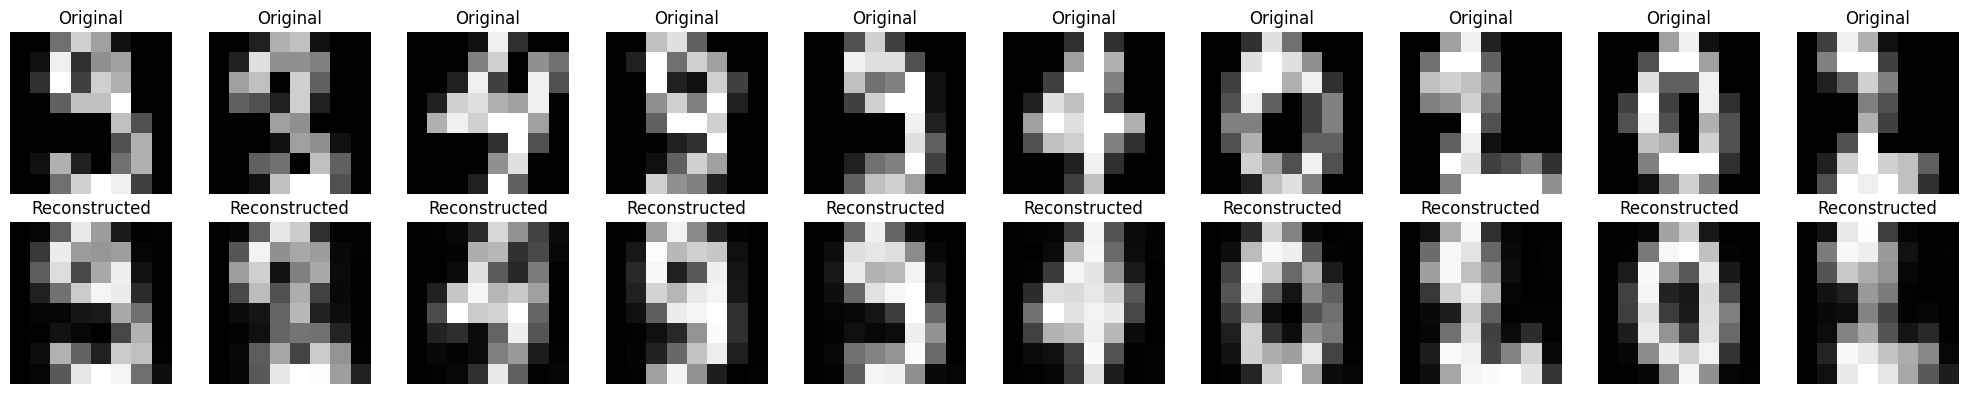

Raw prediction shape: (288, 64)
Predictions shape is already (n_samples, 64).


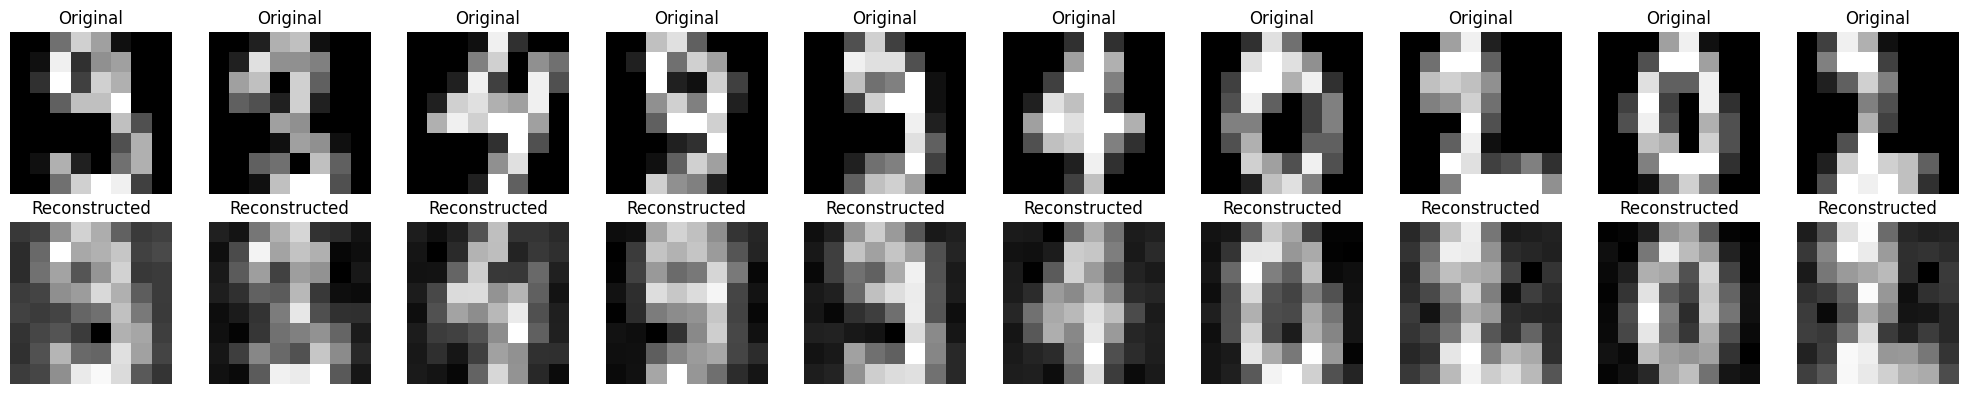

In [18]:
#Comparing the reconstructed images to the original images
def plot_autoencoder_comparison(autoencoder, X, n=10):
    """
    Uses the output of the custom autoencoder's predict method and compares
    the reconstructed images to the original digits.
    
    Parameters:
        autoencoder: an instance of your NeuralNetwork autoencoder.
        X: np.array of shape (n_samples, 64)
           Input digit images (flattened 8x8 images).
        n: int
           Number of images to display.
    """
    # Get predictions from the autoencoder.
    predictions = autoencoder.predict(X)
    print("Raw prediction shape:", predictions.shape)
    
    # Check the shape: if needed, transpose. (Our debug shows it's already (n_samples, 64).)
    if predictions.shape[0] == 64 and predictions.shape[1] != 64:
        predictions = predictions.T
        print("Transposed predictions shape:", predictions.shape)
    elif predictions.shape[1] == 64:
        print("Predictions shape is already (n_samples, 64).")
    else:
        raise ValueError("Unexpected output shape from autoencoder.predict: " + str(predictions.shape))
    
    # Ensure we do not exceed available samples.
    n = min(n, X.shape[0])
    
    # Create a 2-row, n-column grid for the images.
    fig, axes = plt.subplots(2, n, figsize=(2 * n, 4))
    
    # Loop over the first n images.
    for i in range(n):
        # Plot the original image.
        axes[0, i].imshow(X[i].reshape(8, 8), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")
        
        # Plot the reconstructed image.
        axes[1, i].imshow(predictions[i].reshape(8, 8), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")
    
    plt.tight_layout()
    plt.show()

plot_autoencoder_comparison(custom_autoencoder, X_val1, n=10)
plot_autoencoder_comparison(autoencoder_sk, X_val1, n=10)

### Hyperparameter Choices Explanation

- **Learning Rate (lr = 0.01):**  
  A moderate learning rate that is neither too high (which might cause overshooting) nor too low (which may slow down convergence). It worked well on this small dataset.

- **Batch Size (10):**  
  A common choice that balances between a stable gradient estimate and computational efficiency, especially given the small dataset size.

- **Epochs (100):**  
  The number of epochs was chosen to ensure sufficient training iterations for the autoencoder to learn a meaningful compressed representation of the input data.

- **Loss Function (MSE):**  
  Mean Squared Error is well-suited for reconstruction tasks as it directly measures the average squared difference between the input and its reconstruction.

This autoencoder architecture (64x16x64) compresses the original 64-dimensional data into a 16-dimensional latent space and then reconstructs the input. The training and validation loss plots, along with the average reconstruction error on the validation set, help assess how well the model learns to reconstruct the inputs.

Started with initial parameters at lr = 0.001 and batch size 32 which gave a curve that did not plateau yet, I cranked up the learning rate and decreased the batch size and the curve looks reasonable. 

We see that the train loss is still dreasing and that the test loss has not stopped decreasing indicating we aren't overfitting yet.

Looking at the output digits of our autoencoder, the images look reasonably close to their inputs which suggests to me that the autoencoder is properly able to encode and decode the images.